In [1]:
%load_ext autoreload
%autoreload 2

from utils.prediction_models import *

In [2]:
DIR_data="/home/zeqianli/project/zeqian/Carbon/data"
zeqian=pd.read_pickle(f"{DIR_data}/zeqian/zeqian.pk")
matti=pd.read_pickle(f"{DIR_data}/matti/matti.pk")
bacdive=pd.read_pickle(f"{DIR_data}/bacdive/bacdive.pk")
datasets={"zeqian":zeqian,"matti":matti,"bacdive":bacdive,}

# bacdive_sim=pd.read_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/20221031_bacdive_simulated_data.pk")

# Figure 1

See `figure_1.ipynb`. I have to seperate it to a different notebook to run on a different conda environment with older Python because of ete3 compatibility issue. 

# Figure 2

## 2A: FBA, null, phylogeny models, ZL data, random partition

Left to right: null_bernoulli, FBA, 16S nearest neighbor, genome nearest neighbor 

In [8]:
# Zeqian
ko_data, growth_data, tree=zeqian['ko_data'],zeqian['growth_data'],zeqian['tree']
results_all=[]


# Zeqian 16S
from genomics_utils import IO
sixteenS_data=IO.read_fasta(f"{DIR_data}/zeqian/zeqian_16S.aligned.fna",df=True)
sixteenS_data=pd.DataFrame([list(s) for s in sixteenS_data.seq],index=sixteenS_data.id)
sixteenS_data=sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
sixteenS_data.index=sixteenS_data.index.str.replace('zeqian_','')
sixteenS_data=sixteenS_data.loc[zeqian['samples']]

In [31]:
DIR_figure=f"{DIR_data}/figure_data/2A"


threads=1
models={'fba':[FBAClassifier,
                {'model_params':{c: {'c':c,
                                'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba.csv",
                                'growth_threshold':0.05} for c in CARBONS},
                'split_method':{c:[growth_data.index.values] for c in CARBONS},
                'threads':1,
                'allow_empty_set':True,
                'save_models':False
                }
                ],
        'fba_gapfill':[FBAClassifier,
                {'model_params':{c: {'c':c,
                                'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba_gapfill.csv",
                                'growth_threshold':0.05} for c in CARBONS},
                'split_method':{c:[growth_data.index.values] for c in CARBONS},
                'threads':1,
                'allow_empty_set':True,
                'save_models':False
                }
                ],
        'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
        'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': threads,
                 'tree':zeqian['tree'],
                 'save_models':False
                 }],
                
        'NN':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }
              ],
        'NN_ooc':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'tree':zeqian['tree'],
                'save_models':False
                }
                ],
        
}

matrices={'zeqian_16s': [sixteenS_data,growth_data],
          'zeqian_genome': [ko_data,growth_data]
        }

In [32]:
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            print(f"Running {dataset_name} {model_name}")
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            if os.path.exists(ff_results):
                print("Already exists. Skipping. ")
                continue

            pipe=PredictionPipeline(Model,**pipe_params)
            pipe.generate_splits(X,y)
            results=pipe.run()
            with open(ff_results, 'wb') as f:
                pickle.dump(results, f)
        except Exception as e: 
            print(e)
            print(f"Failed to run {dataset_name} {model_name}")


Running zeqian_16s fba


Training models...: 100%|██████████| 10/10 [00:00<00:00, 22.47it/s]


Running zeqian_genome fba


Training models...: 100%|██████████| 10/10 [00:00<00:00, 46.61it/s]


Running zeqian_16s fba_gapfill


Training models...: 100%|██████████| 10/10 [00:00<00:00, 23.98it/s]


Running zeqian_genome fba_gapfill


Training models...: 100%|██████████| 10/10 [00:00<00:00, 32.76it/s]

Running zeqian_16s null
Already exists. Skipping. 
Running zeqian_genome null
Already exists. Skipping. 
Running zeqian_16s null_ooc
Already exists. Skipping. 
Running zeqian_genome null_ooc
Already exists. Skipping. 
Running zeqian_16s NN
Already exists. Skipping. 
Running zeqian_genome NN
Already exists. Skipping. 
Running zeqian_16s NN_ooc
Already exists. Skipping. 
Running zeqian_genome NN_ooc
Already exists. Skipping. 


In [34]:
results_all=[]
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            results=pd.read_pickle(ff_results)
            results['model']=model_name
            results['dataset_name']=dataset_name
            results_all.append(results)
        except Exception as e:
            print(e)
            print(f"Failed to load {dataset_name} {model_name}")

results_all=pd.concat(results_all,axis=0,ignore_index=True)

In [36]:
results_all.to_pickle(f"{DIR_data}/figure_data/2A/results_all.pk")

In [54]:
# p-value

results_all=pd.read_pickle(f"{DIR_data}/figure_data/2A/results_all.pk")
stat=compare_models(results_all[results_all['dataset_name']=='zeqian_16s'], 
                    model_pairs=[
                        ('fba','null',one_sample_test),
                        ('fba_gapfill','null',one_sample_test),
                        ('NN','null',ttest_permutation),
                        ('NN_ooc','null_ooc',ttest_permutation)
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction=True)

stat.to_pickle(f"{DIR_data}/figure_data/2A/stat.pk")

100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


### Plot

In [45]:
plt.rcParams['axes.axisbelow'] = True


In [55]:
results_all=pd.read_pickle(f"{DIR_data}/figure_data/2A/results_all.pk")
stats=pd.read_pickle(f"{DIR_data}/figure_data/2A/stat.pk").set_index('carbon_name')

df=results_all[results_all['dataset_name']=='zeqian_16s']
hue_order=['null','fba','NN','null_ooc','NN_ooc']
df=df[df['model'].isin(hue_order)]

# four color blind friendly colors
colors=['grey','#0072B2','#D55E00', 'grey','#CC79A7'] # ,'#009E73'

sns.catplot(data=df, x='carbon_name',y='accuracy',
            hue='model', hue_order=hue_order, palette=colors,
            kind='violin',height=4, aspect=5,cut=0,linewidth=0.75,inner='box',dodge=True)
#sns.stripplot(data=results_all[results_all['model'].str.contains('fba')], x='carbon_name',y='accuracy',hue='model',legend=False,jitter=False,dodge=True)

ax=plt.gca()
ax.grid()
# ax.grid()

# x axis rotate 90 degree
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Draw FBA line by wizardry 

half_violin=0.4/len(hue_order)
epsilon=0.03
for i,carbon in enumerate(ax.get_xticklabels()):
    y=df[df['carbon_name']==carbon.get_text()]['accuracy'].values[0]
    x=i-half_violin*(len(hue_order)-3)

    ax.plot([x-half_violin+epsilon,x+half_violin-epsilon],[y,y],color=colors[1],linewidth=2)


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Glycerol_null_ooc vs. Glycerol_NN_ooc: Custom statistical test with Bonferroni correction, P_val:1.000e+00
Mannitol_null vs. Mannitol_fba: Custom statistical test with Bonferroni correction, P_val:1.000e+00
Mannitol_null_ooc vs. Mannitol_NN_ooc: Custom statistical test with Bonferroni correction, P_val:1.000e+00
Mannose_null vs. Mannose_fba: Custom statistical test with Bonferroni correction, P_val:1.000e+00
Arabinose_null vs. Arabinose_fba: Custom statistical test with Bonferroni correction, P_val:1.000e+00
Arabinose_null_ooc vs. Arabinose_NN_ooc: Custom statistical test with Bonferroni correction, P_val:1.000e+00
Glucuronic acid_null vs. Glucuronic acid_fba: Custom statistical test with Bonferroni correction, P_val:1.000e+00
Glucuronic acid_null_ooc vs. Glucuronic acid_NN_ooc: Custom statistical test with 

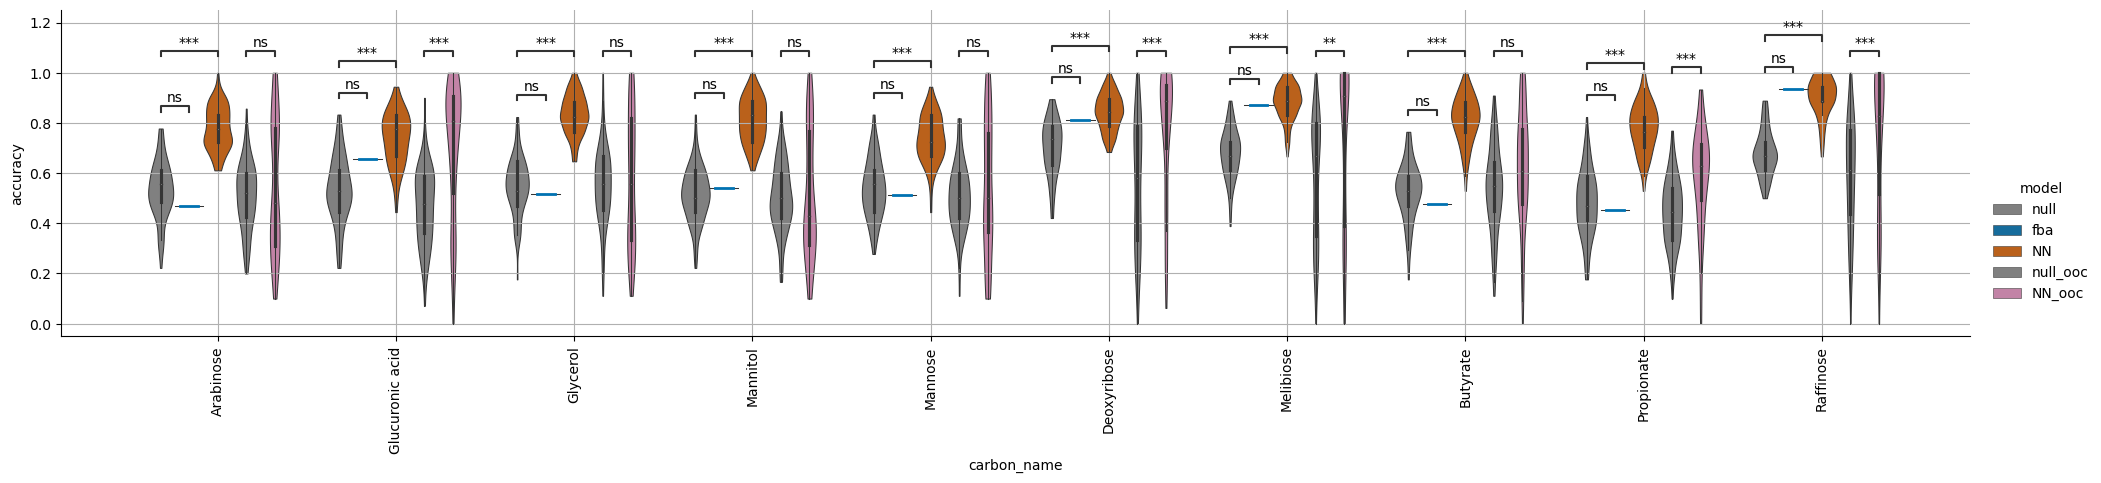

In [56]:

# annotate p-value
from statannotations.Annotator import Annotator

pairs=[]
p_values=[]
model_pairs=[('fba','null'),('NN','null'),('NN_ooc','null_ooc')]
for c in df['carbon_name'].unique():
    for m1,m2 in model_pairs:
        pairs.append(((c,m1),(c,m2)))
        p_values.append(stats.at[c,f'{m1}_{m2}_p'])

annot=Annotator(ax, 
                pairs, 
                data=df,
                x='carbon_name',
                y='accuracy',hue='model',
                hue_order=hue_order)
annot.configure(test=None, comparisons_correction="Bonferroni").set_pvalues(p_values).annotate()

plt.gcf()

TODO: scatter plot, put together with 2B. 

## 2B: distribution of model scores, three data sets

### Matti

In [65]:
# Matti
ko_data, growth_data, tree,carbons=matti['ko_data'],matti['growth_data'],matti['tree'],matti['carbons']
results_all=[]

# Matti 16S
from genomics_utils import IO
sixteenS_data=IO.read_fasta(f"{DIR_data}/matti/matti_16S.aligned.fna",df=True)
sixteenS_data=pd.DataFrame([list(s) for s in sixteenS_data.seq],index=sixteenS_data.id)
sixteenS_data=sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
sixteenS_data.index=sixteenS_data.index.str.replace('matti_','')
sixteenS_data=sixteenS_data.loc[matti['samples']]

In [68]:
# Run this cell for multithreading. Recycle the same Pool. Do not open multiple pools. 
threads=48
p=None
# p=Pool(threads)

In [69]:
DIR_figure=f"{DIR_data}/figure_data/2B"
models={
        # 'fba':[FBAClassifier,
        #         {'model_params':{c: {'c':c,
        #                         'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba.csv",
        #                         'growth_threshold':0.05} for c in CARBONS},
        #         'split_method':{c:[growth_data.index.values] for c in CARBONS},
        #         'threads':1,
        #         'allow_empty_set':True,
        #         'save_models':False
        #         }
        #         ],
        # 'fba_gapfill':[FBAClassifier,
        #         {'model_params':{c: {'c':c,
        #                         'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba_gapfill.csv",
        #                         'growth_threshold':0.05} for c in CARBONS},
        #         'split_method':{c:[growth_data.index.values] for c in CARBONS},
        #         'threads':1,
        #         'allow_empty_set':True,
        #         'save_models':False
        #         }
        #         ],
        'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'p':p,
                 'save_models':False,
                 'carbons':carbons,
                 }],
        'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': threads,
                 'tree':matti['tree'],
                 'p':p,
                 'save_models':False,
                 'carbons':carbons
                 }],
                
        'NN':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'p':p,
                 'save_models':False,
                 'carbons':carbons
                 }
              ],
        'NN_ooc':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'tree':matti['tree'],
                'p':p,
                'save_models':False,
                'carbons':carbons
                }
                ]
}

matrices={'matti_16s': [sixteenS_data,growth_data],
          'matti_genome': [ko_data,growth_data]
        }


In [ ]:
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            print(f"Running {dataset_name} {model_name}")
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            if os.path.exists(ff_results):
                print("Already exists. Skipping. ")
                continue

            pipe=PredictionPipeline(Model,**pipe_params)
            pipe.generate_splits(X,y)
            results=pipe.run()
            with open(ff_results, 'wb') as f:
                pickle.dump(results, f)
        except Exception as e: 
            print(e)
            print(f"Failed to run {dataset_name} {model_name}")


In [70]:
results_all=[]
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            results=pd.read_pickle(ff_results)
            results['model']=model_name
            results['dataset_name']=dataset_name
            results_all.append(results)
        except Exception as e:
            print(e)
            print(f"Failed to load {dataset_name} {model_name}")

results_all=pd.concat(results_all,axis=0,ignore_index=True)

In [71]:
results_all.to_pickle(f"{DIR_data}/figure_data/2B/matti_results_all.pk")

In [59]:
# p-value


results_all=pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_results_all.pk")

stat=compare_models(results_all[results_all['dataset_name']=='matti_16s'], 
                    model_pairs=[
                        # (('fba','null'),one_sample_test),
                        # (('fba_gapfill','null'),one_sample_test),
                        ('NN','null',ttest_permutation),
                        ('NN_ooc','null_ooc',ttest_permutation),
                        ('NN',single_model_summary),
                        ('NN_ooc',single_model_summary),
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy')

stat.to_pickle(f"{DIR_data}/figure_data/2B/matti_stat.pk")

100%|██████████| 118/118 [03:09<00:00,  1.61s/it]


In [66]:
df=stat[['NN_null_significant','NN_ooc_null_ooc_significant']]


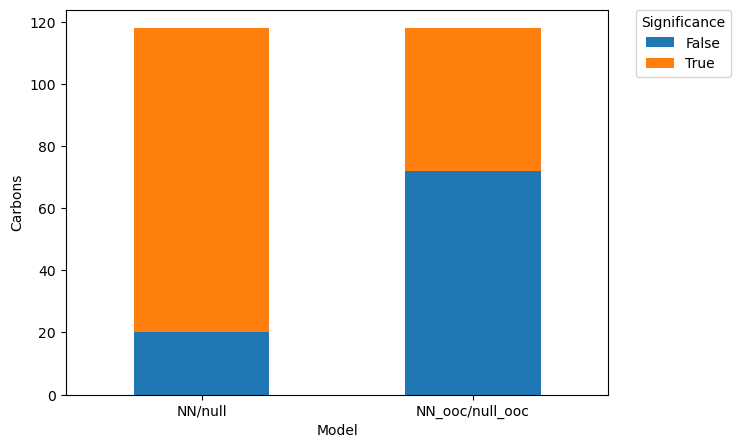

In [76]:
df.apply(lambda s: s.value_counts(),axis=0, result_type='expand').T.plot.bar(stacked=True)

# legend to the right
plt.legend(bbox_to_anchor=(1.05, 1), title='Significance',loc=2, borderaxespad=0.)

plt.xticks(ticks=plt.xticks()[0], labels=['NN/null','NN_ooc/null_ooc'], rotation=0)
plt.ylabel("Carbons")
plt.xlabel("Model")
plt.gcf()

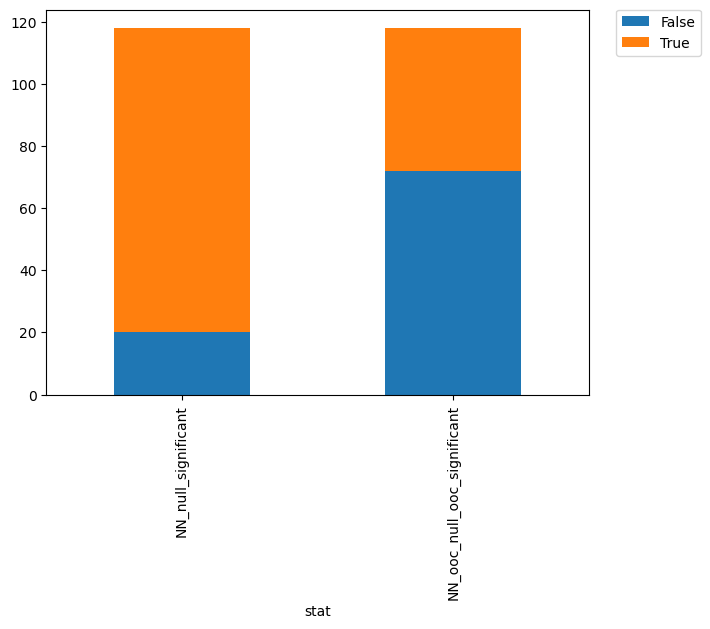

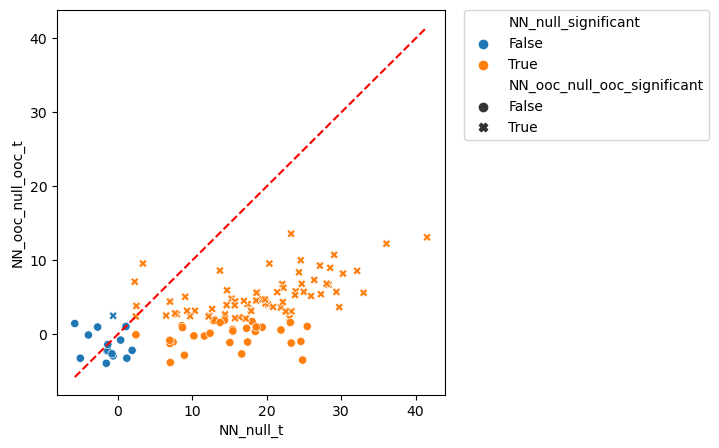

In [16]:
# Option 1
fig=plt.figure(figsize=(5,5))
sns.scatterplot(data=stat, x='NN_null_t',y="NN_ooc_null_ooc_t", hue='NN_null_significant', style='NN_ooc_null_ooc_significant')
# legend on the right outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# draw a line y=x
x=np.linspace(stat['NN_null_t'].min(),stat['NN_null_t'].max(),100)
plt.plot(x,x,'r--')


<AxesSubplot: xlabel='NN_ooc_null_ooc_t', ylabel='NN_ooc_mean'>

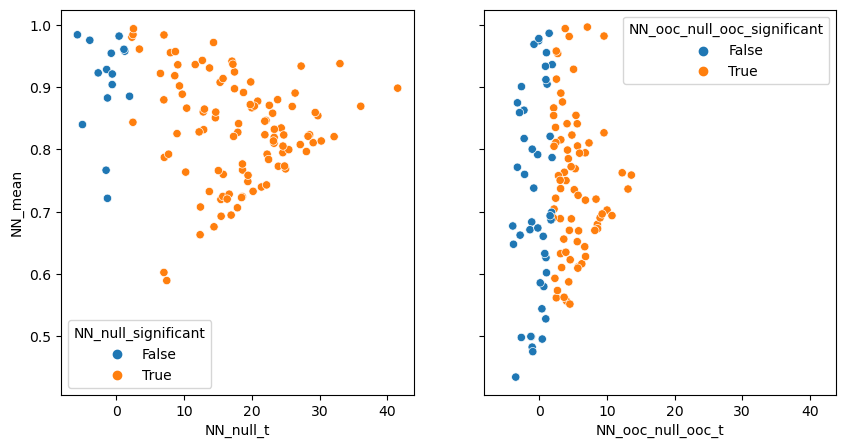

In [9]:
# Option 2
fig,axes=plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
sns.scatterplot(data=stat, x='NN_null_t',y="NN_mean", hue='NN_null_significant',ax=axes[0])
sns.scatterplot(data=stat, x='NN_ooc_null_ooc_t',y="NN_ooc_mean", hue='NN_ooc_null_ooc_significant',ax=axes[1])

Another option: x = mean_growth, y=NN_null_t

Also, how to deal with negative t stat? 

### BacDive

In [ ]:
# BacDive
ko_data, growth_data, tree,carbons=bacdive['ko_data'],bacdive['growth_data'],bacdive['tree'],bacdive['carbons']
results_all=[]

#TODO: 16S for bacdive is too large. Need to use the pre-calcualted distance matrix for bacdive. Do this later. 

In [ ]:
# Run this cell for multithreading. Recycle the same Pool. Do not open multiple pools. 
threads=48
p=Pool(threads)

In [ ]:
DIR_figure=f"{DIR_data}/figure_data/2B"
models={
        # 'fba':[FBAClassifier,
        #         {'model_params':{c: {'c':c,
        #                         'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba.csv",
        #                         'growth_threshold':0.05} for c in CARBONS},
        #         'split_method':{c:[growth_data.index.values] for c in CARBONS},
        #         'threads':1,
        #         'allow_empty_set':True,
        #         'save_models':False
        #         }
        #         ],
        # 'fba_gapfill':[FBAClassifier,
        #         {'model_params':{c: {'c':c,
        #                         'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba_gapfill.csv",
        #                         'growth_threshold':0.05} for c in CARBONS},
        #         'split_method':{c:[growth_data.index.values] for c in CARBONS},
        #         'threads':1,
        #         'allow_empty_set':True,
        #         'save_models':False
        #         }
        #         ],
        'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'p':p,
                 'save_models':False,
                 'carbons':carbons,
                 }],
        'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': threads,
                 'tree':bacdive['tree'],
                 'p':p,
                 'save_models':False,
                 'carbons':carbons
                 }],
                
        'NN':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'p':p,
                 'save_models':False,
                 'carbons':carbons
                 }
              ],
        'NN_ooc':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'tree':bacdive['tree'],
                'p':p,
                'save_models':False,
                'carbons':carbons
                }
                ]
}

matrices={ 
        # 'matti_16s': [sixteenS_data,growth_data],
          'bacdive_genome': [ko_data,growth_data]
        }


In [ ]:
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            print(f"Running {dataset_name} {model_name}")
            ff_cache=os.path.join(DIR_figure,'cache',f'{dataset_name}_{model_name}.pk')
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            if os.path.exists(ff_results):
                print("Already exists. Skipping. ")
                continue
            pipe=PredictionPipeline(Model,ff_results=ff_cache,**pipe_params)
            pipe.generate_splits(X,y)
            results=pipe.run()
            with open(ff_results, 'wb') as f:
                pickle.dump(results, f)
        except Exception as e: 
            print(e)
            print(f"Failed to run {dataset_name} {model_name}")


Running zeqian_16s fba


Training models...: 100%|██████████| 10/10 [00:00<00:00, 22.47it/s]


Running zeqian_genome fba


Training models...: 100%|██████████| 10/10 [00:00<00:00, 46.61it/s]


Running zeqian_16s fba_gapfill


Training models...: 100%|██████████| 10/10 [00:00<00:00, 23.98it/s]


Running zeqian_genome fba_gapfill


Training models...: 100%|██████████| 10/10 [00:00<00:00, 32.76it/s]

Running zeqian_16s null
Already exists. Skipping. 
Running zeqian_genome null
Already exists. Skipping. 
Running zeqian_16s null_ooc
Already exists. Skipping. 
Running zeqian_genome null_ooc
Already exists. Skipping. 
Running zeqian_16s NN
Already exists. Skipping. 
Running zeqian_genome NN
Already exists. Skipping. 
Running zeqian_16s NN_ooc
Already exists. Skipping. 
Running zeqian_genome NN_ooc
Already exists. Skipping. 


In [ ]:
results_all=[]
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            results=pd.read_pickle(ff_results)
            results['model']=model_name
            results['dataset_name']=dataset_name
            results_all.append(results)
        except Exception as e:
            print(e)
            print(f"Failed to load {dataset_name} {model_name}")

results_all=pd.concat(results_all,axis=0,ignore_index=True)

In [ ]:
results_all.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_results_all.pk")

In [ ]:
# p-value

results_all=pd.read_pickle(f"{DIR_data}/figure_data/2B/bacdive_results_all.pk")
stat=compare_models(results_all[results_all['dataset_name']=='bacdive_genome'], 
                    model_pairs=[
                        # (('fba','null'),one_sample_test),
                        # (('fba_gapfill','null'),one_sample_test),
                        (('NN','null'),ttest),
                        (('NN_ooc','null_ooc'),ttest)
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy')

stat.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_stat.pk")

TODO: I don't know why this figure looks insane. Probably because of rare carbons. Filter the carbons with enough sampels in the future. 

## 2C: Phylogeny - trait correlation plot

See figure_2C.ipynb 

# Figure 3

## 3A: models 

Left: Null, FBA, NN-genomes, NN-RF, NN-OOC, feature selection

Right: FI

In [10]:
threads=48
p=None
#p=Pool(threads)

In [11]:
DIR_figure=f"{DIR_data}/figure_data/3A"


models={'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
        'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
                
        'NN':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }
              ],
        'NN_ooc':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False
                }
                ],
        'RF':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': 'sqrt'},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                },
        ],
        'RF_ooc':[RF,
                {'model_params':{'n_estimators':100,'max_depth':None, 'max_features': 'sqrt'},
                'split_method':'ooc',   
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'save_models':False
                }],
        'GreedyFeatureSelection':[GreedyFeatureSelection,
                {'model_params':{
                    "Model":DecisionTree, 
                    'tree':zeqian['tree'],
                    "model_params":{},
                    "n_max_features":3, 
                    "n_feature_subsample":None,
                    "n_meta_split":10, 
                    "split_method":'ooc',
                    "splitter_params":{'test_set_range':(0.1,0.3),'min_zeros':0,'min_ones':0,'time_out_iter':None},
                    "threads":threads,                    
                    "save_meta_models":False,
                    'verbose':False,
                    'p':p,},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':10,
                'threads':1,
                'save_models':False,
                }]
}

matrices={
          'zeqian_genome': zeqian
        }


In [ ]:
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,dataset in matrices.items():
        try:
            print(f"Running {dataset_name} {model_name}")
            ff_cache=os.path.join(DIR_figure,'cache',f'{dataset_name}_{model_name}.pk')
            ff_results=os.path.join(DIR_figure,'results',f'{dataset_name}_{model_name}.pk')
            if os.path.exists(ff_results):
                print("Already exists. Skipping. ")
                continue
            ko_data,growth_data, tree,carbons=dataset['ko_data'],dataset['growth_data'],dataset['tree'],dataset['carbons']
            pipe=PredictionPipeline(Model, tree=tree, carbons=carbons, p=p,  ff_results=ff_cache, **pipe_params)
            pipe.generate_splits(ko_data,growth_data)
            results=pipe.run()
            with open(ff_results, 'wb') as f:
                pickle.dump(results, f)
            print(f"Finished {dataset_name} {model_name} ")
        except Exception as e: 
            print(e)
            print(f"Failed to run {dataset_name} {model_name}")


In [13]:
results_all=[]
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,dataset in matrices.items():
        try:
            ff_results=os.path.join(DIR_figure,'results',f'{dataset_name}_{model_name}.pk')
            results=pd.read_pickle(ff_results)
            results['model']=model_name
            results['dataset_name']=dataset_name
            results_all.append(results)
        except Exception as e:
            print(e)
            print(f"Failed to load {dataset_name} {model_name}")

results_all=pd.concat(results_all,axis=0,ignore_index=True)
results_all.to_pickle(f"{DIR_data}/figure_data/3A/zeqian_results_all.pk")

[Errno 2] No such file or directory: '/home/zeqianli/project/zeqian/Carbon/data/figure_data/3A/results/zeqian_genome_GreedyFeatureSelection.pk'
Failed to load zeqian_genome GreedyFeatureSelection


In [4]:
results_all=pd.read_pickle(f"{DIR_data}/figure_data/3A/zeqian_results_all.pk")


In [16]:
# p-value

results_all=pd.read_pickle(f"{DIR_data}/figure_data/3A/zeqian_results_all.pk")
stat=compare_models(results_all, 
                    model_pairs=[
                        ('NN','null',ttest_permutation),
                        ('NN_ooc','null_ooc',ttest_permutation),
                        ('RF','null',ttest_permutation),
                        ('RF_ooc','null_ooc',ttest_permutation)
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy',
                    p_threshold=0.05,
                    multi_testing_correction=True)

stat.to_pickle(f"{DIR_data}/figure_data/3A/zeqian_stat.pk")

100%|██████████| 10/10 [00:32<00:00,  3.20s/it]


### Plot

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Mannitol_null vs. Mannitol_RF: Custom statistical test with Bonferroni correction, P_val:4.000e-04
Mannose_null vs. Mannose_RF: Custom statistical test with Bonferroni correction, P_val:4.000e-04
Melibiose_null vs. Melibiose_RF: Custom statistical test with Bonferroni correction, P_val:4.000e-04
Propionate_null vs. Propionate_RF: Custom statistical test with Bonferroni correction, P_val:4.000e-04
Propionate_null_ooc vs. Propionate_RF_ooc: Custom statistical test with Bonferroni correction, P_val:4.000e-04
Raffinose_null_ooc vs. Raffinose_RF_ooc: Custom statistical test with Bonferroni correction, P_val:4.212e-01
Butyrate_null vs. Butyrate_RF: Custom statistical test with Bonferroni correction, P_val:4.000e-04
Butyrate_null_ooc vs. Butyrate_RF_ooc: Custom statistical test with Bonferroni correction, P_val:4.0

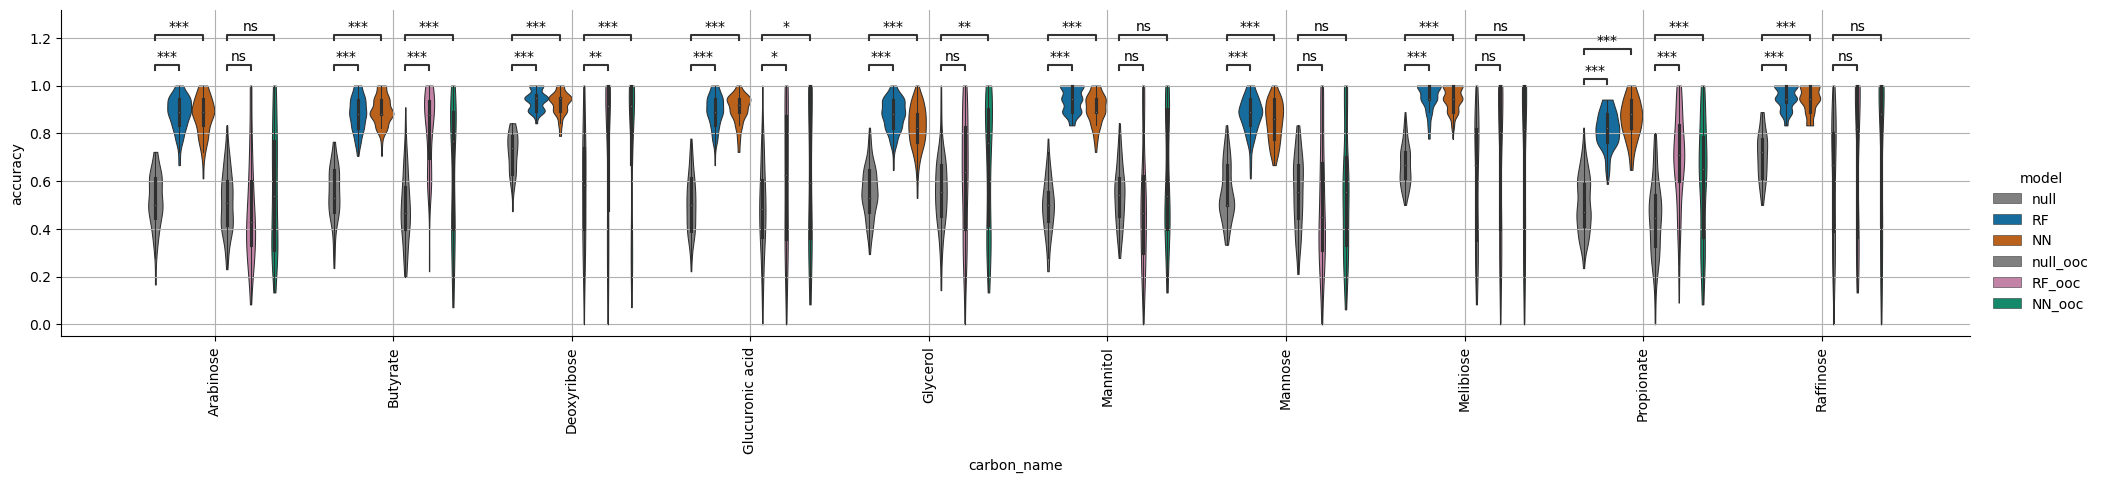

In [23]:
results_all=pd.read_pickle(f"{DIR_data}/figure_data/3A/zeqian_results_all.pk")
stats=pd.read_pickle(f"{DIR_data}/figure_data/3A/zeqian_stat.pk").set_index('carbon_name')

df=results_all
hue_order=['null','RF','NN','null_ooc','RF_ooc','NN_ooc']
df=df[df['model'].isin(hue_order)]

# four color blind friendly colors
colors=['grey','#0072B2','#D55E00', 'grey','#CC79A7','#009E73'] 

sns.catplot(data=df, x='carbon_name',y='accuracy',
            hue='model', hue_order=hue_order, palette=colors,
            kind='violin',height=4, aspect=5,cut=0,linewidth=0.75,inner='box',dodge=True)
#sns.stripplot(data=results_all[results_all['model'].str.contains('fba')], x='carbon_name',y='accuracy',hue='model',legend=False,jitter=False,dodge=True)

ax=plt.gca()
ax.grid()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# annotate p-value
from statannotations.Annotator import Annotator

pairs=[]
p_values=[]
model_pairs=[('NN','null'),
            ('NN_ooc','null_ooc'),
            ('RF','null'),
            ('RF_ooc','null_ooc')]
for c in df['carbon_name'].unique():
    for m1,m2 in model_pairs:
        pairs.append(((c,m1),(c,m2)))
        p_values.append(stats.at[c,f'{m1}_{m2}_p'])

annot=Annotator(ax, 
                pairs, 
                data=df,
                x='carbon_name',
                y='accuracy',hue='model',
                hue_order=hue_order)
annot.configure(test=None, comparisons_correction="Bonferroni").set_pvalues(p_values).annotate()

plt.gcf()

### Feature importance

In [46]:
results_all=pd.read_pickle(f"{DIR_data}/figure_data/3A/zeqian_results_all.pk")

carbon_kos=[]
DIR_kegg_pathway="/home/zeqianli/project/zeqian/Carbon/data/kegg/pathways"
for pathway in os.listdir(DIR_kegg_pathway):
    carbon_kos.extend(pd.read_csv(os.path.join(DIR_kegg_pathway,pathway,'kos.txt'),sep='\t',header=None).values)
carbon_kos=np.unique(carbon_kos)

df_kegg=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/kegg/zeqian_kos_by_kegg.pk")
highlight_keys=['by_pathway','by_k3_path_directed','by_reaction']
highlight_dict={}
for c, row in df_kegg.iterrows():
    highlight_dict[c]={'carbon_metabolism': carbon_kos}
    for key in highlight_keys:
        highlight_dict[c][key]=row[key]

colors={'': 'grey', 'carbon_metabolism': '#0072B2', 'by_pathway': '#D55E00', 'by_k3_path_directed': '#CC79A7', 'by_reaction': '#009E73'}

/home/zeqianli/ipykernel_1662573/3926369727.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


Text(0.5, 1.0, 'Zeqian data, RF, random partition')

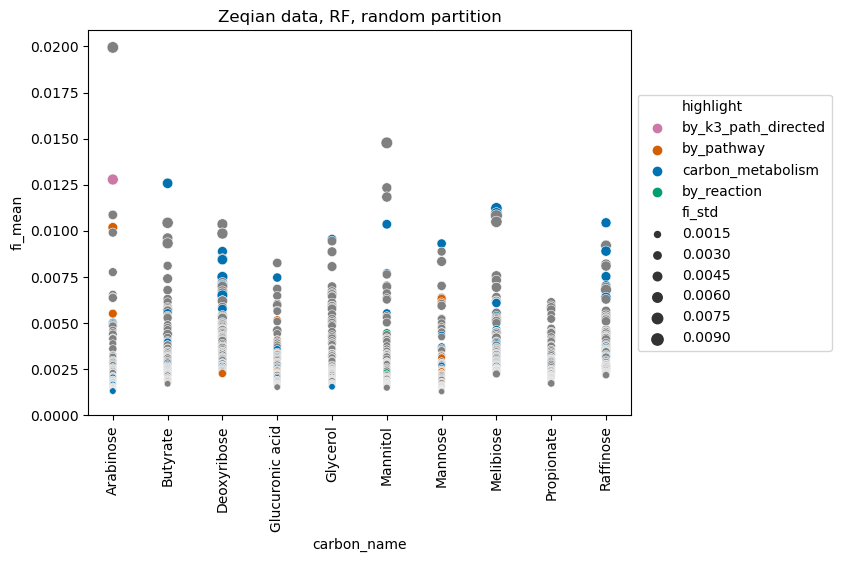

In [48]:
fi=cal_feature_importance(results_all[results_all['model']=='RF'], zeqian['ko_data'],highlight=highlight_dict,trim=100)
sns.scatterplot(data=fi, x='carbon_name',y='fi_mean',hue='highlight',size='fi_std',palette=colors)

# legend out, x lable 90
ax=plt.gca()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(bottom=0)

plt.title("Zeqian data, RF, random partition")


/home/zeqianli/ipykernel_1662573/1673225842.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


Text(0.5, 1.0, 'Zeqian data, RF_ooc, random partition')

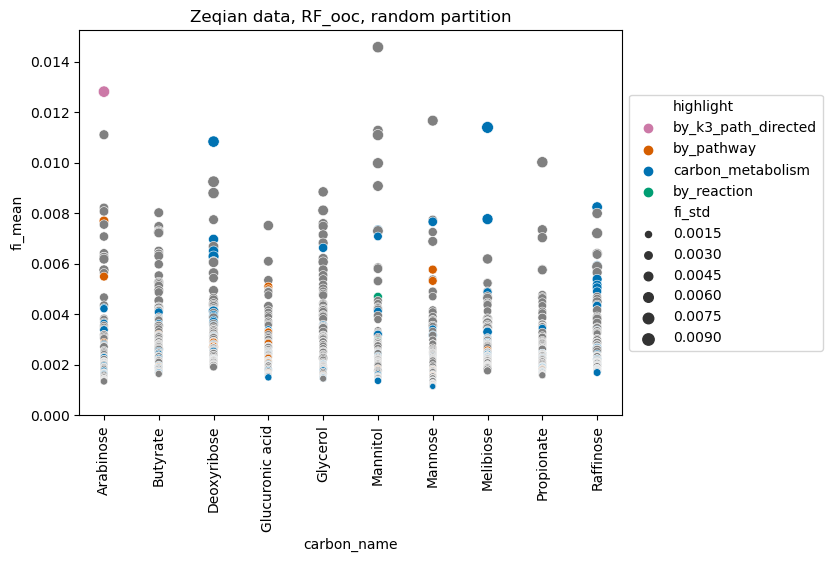

In [50]:
fi=cal_feature_importance(results_all[results_all['model']=='RF_ooc'], zeqian['ko_data'],highlight=highlight_dict,trim=100)
sns.scatterplot(data=fi, x='carbon_name',y='fi_mean',hue='highlight',size='fi_std',palette=colors)

# legend out, x lable 90
ax=plt.gca()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(bottom=0)

plt.title("Zeqian data, RF_ooc, random partition")


## 3B: Synthetic data phase space

See figure_3b.ipynb

# Figure 4

## 4A: color KEGG pathways

Use [KEGG Mapper Color](https://www.genome.jp/kegg/mapper/color.html) to plot an example. 

In [3]:
df=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/kegg/zeqian_kos_by_kegg.pk")

In [41]:
def generate_kegg_color_texts(df,c, keys=['by_pathway','by_k3_path_directed','by_reaction'],compound_color='red',edge_colors=['yellow','pink','cyan']):
    row=df.loc[c]
    print(f"{row['carbon']}\t{compound_color}")
    colors={}
    for key, edge_color in zip(keys, edge_colors[:len(keys)]):
        for ko in row[key]:
            colors[ko]=edge_color
    
    for ko, c in colors.items():
        print(f"{ko}\t{c}")
    



In [46]:
generate_kegg_color_texts(df,'Raffinose',keys=['by_k2_path_undirected','by_reaction'])

C00492	red
K00689	yellow
K00690	yellow
K00695	yellow
K01182	yellow
K01187	yellow
K01189	pink
K01193	pink
K01203	yellow
K05341	yellow
K06617	pink
K07406	pink
K07407	pink
K12047	yellow
K12316	yellow
K12317	yellow
K06611	pink


## 4B. KEGG restricted models

See figure_4B.ipynb

# Archive

## 2A

In [ ]:
# FBA
# The standard pipeline class doesn't work well for this because it checks that the training set and test set must have non-zero samples. Borrow the _pickleable_run_model function. 

fba_paras={c:{'c':c,
              'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba.csv",
              'growth_threshold':0.05} for c in CARBONS}

split_method={c:[growth_data.index.values] for c in CARBONS}
pipe=PredictionPipeline(FBAClassifier,model_params=fba_paras,split_method=split_method,threads=1)
#pipe=PredictionPipeline(FBAClassifier,model_params=fba_paras,split_method='random',splitter_params={'test_set_ratio':0.2},threads=1,n_splits=100)
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='fba'
results_all.append(results)

fba_paras={c:{'c':c,
              'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba_gapfill.csv",
              'growth_threshold':0.05} for c in CARBONS}

split_method={c:[growth_data.index.values] for c in CARBONS}
pipe=PredictionPipeline(FBAClassifier,model_params=fba_paras,split_method=split_method,threads=1)
#pipe=PredictionPipeline(FBAClassifier,model_params=fba_paras,split_method='random',splitter_params={'test_set_ratio':0.2},threads=1,n_splits=100)
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='fba_gapfill'
results_all.append(results)

Training models...: 100%|██████████| 10/10 [00:00<00:00, 25.77it/s]


In [ ]:
# Bernoulli null
pipe=PredictionPipeline(BernoulliNull,split_method='random',splitter_params={'test_set_ratio':0.2},
                        threads=1,n_splits=100)
pipe.generate_splits(ko_data,growth_data)
results_bernoulli=pipe.run()
results_bernoulli['model']='bernoulli'
results_all.append(results_bernoulli)

Training models...: 100%|██████████| 1000/1000 [00:01<00:00, 568.08it/s]


In [ ]:

# Nearest neighbor, 16S
from genomics_utils import IO
sixteenS_data=IO.read_fasta(f"{DIR_data}/zeqian/zeqian_16S.aligned.fna",df=True)
sixteenS_data=pd.DataFrame([list(s) for s in sixteenS_data.seq],index=sixteenS_data.id)
X=sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
X.index=X.index.str.replace('zeqian_','')
X=X.loc[zeqian['samples']]

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=100,threads=1,p=None)
pipe.generate_splits(X,growth_data)
results=pipe.run()
results['model']='nn_16S'
results_all.append(results)


Training models...: 100%|██████████| 1000/1000 [06:55<00:00,  2.41it/s]


In [ ]:
# Nearest neighbor, genome

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=100,threads=1)
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='nn_genome'
results_all.append(results)

# results_all=pd.concat(results_all,axis=0,ignore_index=True)
# results_all.to_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/figure_data/2A/models_results.pk")

Training models...: 100%|██████████| 1000/1000 [01:13<00:00, 13.62it/s]


## Matti

In [ ]:
# Bernoulli null
pipe=PredictionPipeline(BernoulliNull,split_method='random',splitter_params={'test_set_ratio':0.2},
                        threads=1,n_splits=100,p=None,carbons=carbons,save_models=False)
pipe.generate_splits(ko_data,growth_data)
results_bernoulli=pipe.run()
results_bernoulli['model']='bernoulli'
results_bernoulli.to_pickle(f"{DIR_data}/figure_data/2B/matti_bernoulli.pk")

# results_all.append(results_bernoulli)

Training models...: 100%|██████████| 11800/11800 [00:22<00:00, 524.73it/s]


In [ ]:
# Nearest neighbor, genome

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=100,threads=28,p=p,carbons=carbons,save_models=False)
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='nn_genome'
results.to_pickle(f"{DIR_data}/figure_data/2B/matti_nn_genome.pk")
# results_all.append(results)

# results_all=pd.concat(results_all,axis=0,ignore_index=True)
# results_all.to_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/figure_data/2A/models_results.pk")

Training models...: 100%|███████████████████████████████████████████████████████████████| 11800/11800 [10:47<00:00, 18.23it/s]


In [ ]:

# Nearest neighbor, 16S
from genomics_utils import IO
sixteenS_data=IO.read_fasta(f"{DIR_data}/matti/matti_16S.aligned.fna",df=True)
sixteenS_data=pd.DataFrame([list(s) for s in sixteenS_data.seq],index=sixteenS_data.id)
X=sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
X.index=X.index.str.replace('matti_','')
X=X.loc[matti['samples']]

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=100,threads=28,p=p,carbons=carbons,save_models=False)
pipe.generate_splits(X,growth_data)
results=pipe.run()
results['model']='nn_16S'
results.to_pickle(f"{DIR_data}/figure_data/2B/matti_nn_16S.pk")
# results_all.append(results)


Training models...: 100%|███████████████████████████████████████████████████████████████| 11800/11800 [34:45<00:00,  5.66it/s]


In [ ]:
results_all=pd.concat([pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_bernoulli.pk"),
                    pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_nn_genome.pk"),
                    pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_nn_16S.pk")],axis=0,ignore_index=True)
results_all.to_pickle(f"{DIR_data}/figure_data/2B/matti_models_results.pk")

(-0.1, 1.1)

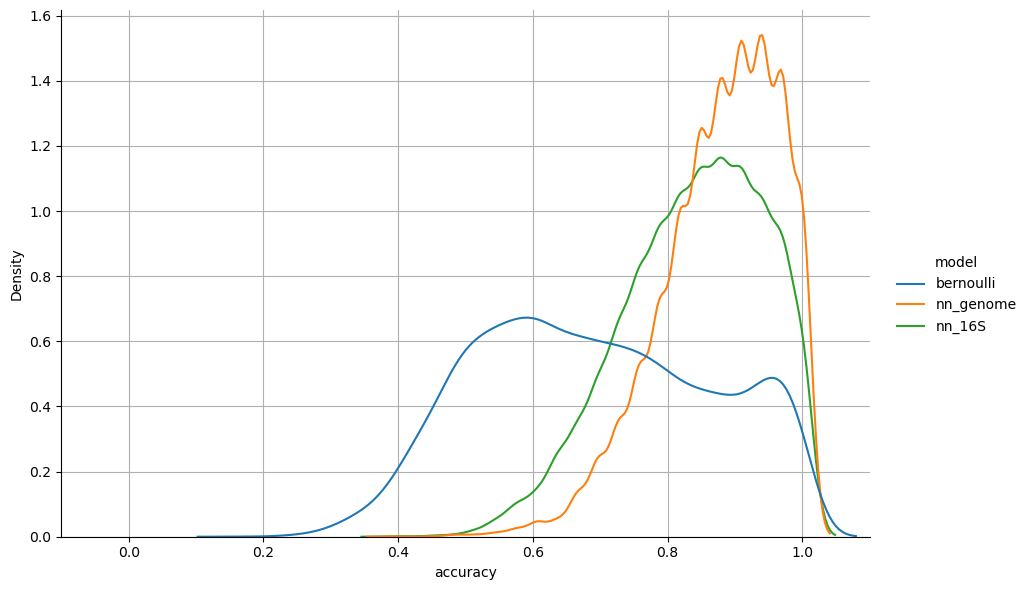

In [ ]:
# Plot
results_all=pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_models_results.pk")
sns.displot(data=results_all, x='accuracy',hue='model',kind='kde',height=6, aspect=1.5,)
#sns.stripplot(data=results_all[results_all['model'].str.contains('fba')], x='carbon_name',y='accuracy',hue='model',legend=False,jitter=False,dodge=True)

ax=plt.gca()
ax.grid()
ax.set_xlim(-0.1,1.1)


TODO: OOC

## Bacdive

In [ ]:
# Run this cell for multithreading. Recycle the same Pool. Do not open multiple pools. 
p=Pool(28)

Process ForkPoolWorker-14:
Process ForkPoolWorker-4:
Process ForkPoolWorker-25:
Process ForkPoolWorker-26:
Process ForkPoolWorker-20:
Process ForkPoolWorker-28:
Process ForkPoolWorker-5:
Process ForkPoolWorker-10:
Process ForkPoolWorker-9:
Process ForkPoolWorker-6:
Process ForkPoolWorker-19:
Process ForkPoolWorker-3:
Process ForkPoolWorker-22:
Process ForkPoolWorker-23:
Process ForkPoolWorker-16:
Process ForkPoolWorker-24:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-12:
Process ForkPoolWorker-21:
Process ForkPoolWorker-8:
Process ForkPoolWorker-17:
Process ForkPoolWorker-7:
Process ForkPoolWorker-27:
Process ForkPoolWorker-18:
Process ForkPoolWorker-13:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-11:
Traceback (most recent call last):
Process ForkPoolWorker-15:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "

In [ ]:
ko_data, growth_data, tree,carbons=bacdive['ko_data'],bacdive['growth_data'],bacdive['tree'],bacdive['carbons']

In [ ]:
# Bernoulli null
pipe=PredictionPipeline(BernoulliNull,split_method='random',splitter_params={'test_set_ratio':0.2},
                        threads=1,n_splits=100,p=None,carbons=carbons,save_models=False, 
                       ff_results=f"{DIR_data}/figure_data/2B/cache/bacdive_bernoulli.pk")
pipe.generate_splits(ko_data,growth_data)
results_bernoulli=pipe.run()
results_bernoulli['model']='bernoulli'
results_bernoulli.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_bernoulli.pk")

# results_all.append(results_bernoulli)

Training models...:  56%|███████████████████████████████████████████████████████████▏                                              | 12297/22000 [00:50<01:01, 157.46it/s]/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zeqianli/scratch-midway3/minicon

In [ ]:
# Nearest neighbor, genome

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=20,threads=28,p=p,carbons=carbons,save_models=False,
                        ff_results=f"{DIR_data}/figure_data/2B/cache/bacdive_nn_genome.pk")
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='nn_genome'
results.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_nn_genome.pk")
# results_all.append(results)

# results_all=pd.concat(results_all,axis=0,ignore_index=True)
# results_all.to_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/figure_data/2A/models_results.pk")

Changed to /home/zeqianli/project/zeqian/Carbon/data/figure_data/2B/cache/bacdive_nn_genome_0.pk. 


Training models...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4360/4360 [02:59<00:00, 24.26it/s]


In [ ]:

# Nearest neighbor, 16S
# from genomics_utils import IO
# sixteenS_data=IO.read_fasta(f"{DIR_data}/bacdive/bacdive_16S.aligned.fna",df=True)
# sixteenS_data=pd.DataFrame([list(s) for s in sixteenS_data.seq],index=sixteenS_data.id)
# X=sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
# X.index=X.index.str.replace('bacdive_','')
# X=X.loc[bacdive['samples']]

# pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
#                         split_method='random',splitter_params={'test_set_ratio':0.2},
#                         n_splits=100,threads=28,p=p,carbons=carbons,save_models=False)
# pipe.generate_splits(X,growth_data)
# results=pipe.run()
# results['model']='nn_16S'
# results.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_nn_16S.pk")

# results_all.append(results)


KeyboardInterrupt: 

In [ ]:
results_all=pd.concat([pd.read_pickle(f"{DIR_data}/figure_data/2B/bacdive_bernoulli.pk"),
                    pd.read_pickle(f"{DIR_data}/figure_data/2B/bacdive_nn_genome.pk")
                    ],axis=0,ignore_index=True)
results_all.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_models_results.pk")

(-0.1, 1.1)

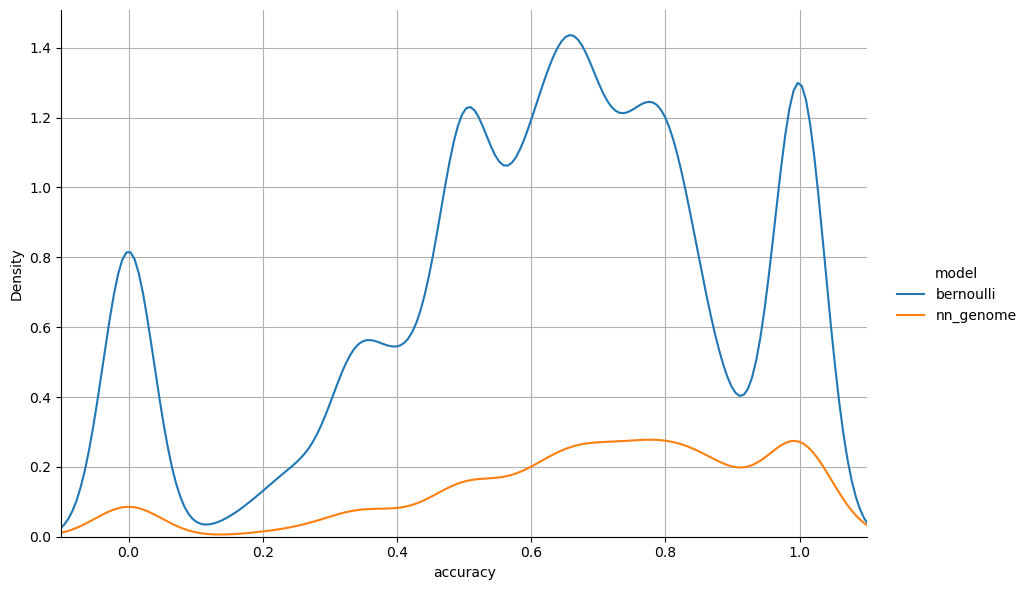

In [ ]:
results_all=pd.read_pickle(f"{DIR_data}/figure_data/2B/bacdive_models_results.pk")
sns.displot(data=results_all, x='accuracy',hue='model',kind='kde',height=6, aspect=1.5,)
#sns.stripplot(data=results_all[results_all['model'].str.contains('fba')], x='carbon_name',y='accuracy',hue='model',legend=False,jitter=False,dodge=True)

ax=plt.gca()
ax.grid()
ax.set_xlim(-0.1,1.1)
# x axis rotate 90 degree
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)



In [ ]:
# # Run this cell for testing 

# threads=1

# models={'RF':[RF,None], 'NN': [NearestNeighbor,None], "LogisticRegression":[LassoLogisticRegression,{'C':1.0, 'penalty':'l1','solver':'liblinear'}]}


# split_params={'random': {
#                  'split_method':'random',
#                  'splitter_params': {'test_set_ratio':0.2}, 
#                  'n_splits':2,
#                  'threads': threads,
#                  'save_models':False
#                  },
#         'ooc': {
#                  'split_method':'ooc',
#                  'splitter_params': {'test_set_range':(0.1,0.25), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None}, 
#                  'n_splits':2,
#                  'threads': threads,
#                  'save_models':False
#                  },
#         # 'loo':{
#         #          'split_method':'leave_one_out',
#         #          'splitter_params': {}, 
#         #          'n_splits':2,
#         #          'threads': threads,
#         #          'save_models':False
#         #          }
#         }